# Autoencoder
#### The idea is to implement autoencoder - neural network where input is bascially mapped to output, and has some "bottleneck" in between. In this case One layer "encodes" and second layer "decodes" the input (from encoder).

#### Importing Libs/APIs

In [1]:
from matplotlib import pyplot as plt
from tensorflow import keras
from keras.callbacks import TensorBoard
import numpy as np
import tensorflow as tf

### Functions

In [2]:
def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [3]:
def makeClassSet(xTrainSet:np.ndarray, yTrainSet:np.ndarray, xTestClass:np.ndarray, yTestClass:np.ndarray, firstclassNumber:int,secondclassNumber:int):
    """Creates a dataset like "tf.keras.datasets.mnist.load_data()" does but with only the classes of interest

    Args:
        xTrainSet (np.ndarray): _description_
        yTrainSet (np.ndarray): _description_
        xTestClass (np.ndarray): _description_
        yTestClass (np.ndarray): _description_
        firstclassNumber (int): _description_
        secondclassNumber (int): _description_

    Returns:
        _type_: _description_
    """
    # xtrain
    firstTrainSet = xTrainSet[yTrainSet == firstclassNumber]
    secondTrainSet = xTrainSet[yTrainSet == secondclassNumber]
    xTrainArray = np.append(firstTrainSet, secondTrainSet, axis=0)
    
    # yTrain
    trainFirstClassY = [firstclassNumber] * firstTrainSet.shape[0]
    trainSecondClassY = [secondclassNumber] * firstTrainSet.shape[0]
    trainYArray = np.append(trainFirstClassY, trainSecondClassY, axis=0)
    
    # xTest
    firstTestSet = xTestClass[yTestClass == firstclassNumber]
    secondTestSet = xTestClass[yTestClass == secondclassNumber]
    xTestArray = np.append(firstTestSet, secondTestSet, axis=0)
    
    # yTest
    testFirstClassY = [firstclassNumber] * firstTestSet.shape[0]
    testSecondClassY = [secondclassNumber] * firstTestSet.shape[0]
    testYArray = np.append(testFirstClassY, testSecondClassY, axis=0)
    
    
    xTrainArray = xTrainArray.reshape((len(xTrainArray), np.prod(xTrainArray.shape[1:])))
    xTestArray = xTestArray.reshape((len(xTestArray), np.prod(xTestArray.shape[1:])))
    
    xTrainArray =  xTrainArray.astype('float32') / (255)
    xTestArray = xTestArray.astype('float32') / (255)

    
    return (xTrainArray, trainYArray), (xTestArray, testYArray)

def prepareAutoencoderModel():
    """Creates and returns the autoencoder and the building models.

    Returns:
        _type_: _description_
    """
    encoding_dimension = 32
    # This is our input image
    input_img = keras.Input(shape=(784,))
    # "encoded" is the encoded representation of the input
    encoded = keras.layers.Dense(encoding_dimension, activation='relu')(input_img)
    # "decoded" is the lossy reconstruction of the input
    decoded =keras.layers.Dense(784, activation='sigmoid')(encoded)

    # This model maps an input to its reconstruction
    autoencoder = keras.Model(input_img, decoded, name='Autoencoder')
    # This model maps an input to its encoded representation
    encoder = keras.Model(input_img, encoded, name='Encoder')
    # This is our encoded (32-dimensional) input
    encoded_input = keras.Input(shape=(encoding_dimension,))
    # Retrieve the last layer of the autoencoder model
    decoder_layer = autoencoder.layers[-1]
    # Create the decoder model
    decoder = keras.Model(encoded_input, decoder_layer(encoded_input), name='Decoder')

    tf.keras.utils.plot_model(autoencoder, to_file='autoencoder.png', show_shapes=True)

    opt = keras.optimizers.Adam(lr=0.001, decay=1e-6) #* Adam optimizer

    autoencoder.compile(optimizer=opt, loss='mse')
    autoencoder.summary()
    return encoder, decoder, autoencoder

def fitTheModel(xTrain: np.ndarray, yTrain: np.ndarray, xTest: np.ndarray, yTest: np.ndarray, encoderModel, decoderModel, autoencoderModel):
    """Returns images - encoded and decoded"""


    es = keras.callbacks.EarlyStopping(patience=10,restore_best_weights=True)
    autoencoder.fit(xTrain, xTrain, epochs=10, batch_size=32,validation_split= 0.1, callbacks=[es, TensorBoard(log_dir='/tmp/autoencoder')], shuffle=True)
    encoded_imgs = encoderModel.predict(xTest)
    decoded_imgs = decoderModel.predict(encoded_imgs)
    autoencoded_imgs = autoencoderModel.predict(xTest)
    
    return encoded_imgs, decoded_imgs, autoencoded_imgs

def plotTheResults(xTest: np.ndarray,encoded_imgs,autoencoded_imgs,  n = 10):
    """Plots the results of the autoencoder

    Args:
        xTest (_type_): _description_
        encoded_imgs (_type_): _description_
        autoencoded_imgs (_type_): _description_
        n (int, optional): _description_. Defaults to 10.
    """
    plt.figure(figsize=(30,8))
    listOfPreviesIndexes = []
    for i in range(n):
        randomIndex =  np.random.randint(0,(xTest.shape[0] ))
        while randomIndex in listOfPreviesIndexes:
            randomIndex =  np.random.randint(0,(xTest.shape[0] ))
        listOfPreviesIndexes.append(randomIndex)
        
        # Display original
        
        ax = plt.subplot(3, n, i + 1)
        plt.imshow(xTest[randomIndex].reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        ax.set_title("Test Image")

        # Display reconstruction
        ax = plt.subplot(3, n, i + 1 + n)
        # plt.imshow(encoded_imgs[i].reshape(28, 28))
        plt.imshow(encoded_imgs[randomIndex].reshape(-1,8), cmap='gray')
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        ax.set_title("Encoded Image")
        
        # Display autoencoder
        ax = plt.subplot(3, n, i + 1 + 2*n)
        plt.imshow(autoencoded_imgs[randomIndex].reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        
        ax.set_title("Output of an autoencoder")
        
    plt.show()

#### Importing default MNIST tensorflow keras data 

Checking the data _>
<class 'numpy.ndarray'>


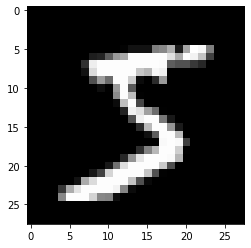

In [4]:
(xTrain, yTrain), (xTest, yTest) = tf.keras.datasets.mnist.load_data()
#? Checking the shape of the data, small preview
print("Checking the data _>")
print(type(xTrain))
plt.imshow(xTrain[0], cmap='gray')


### Modeling the network

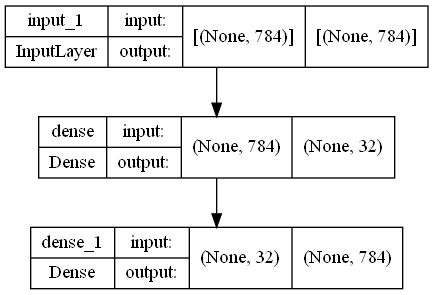

In [5]:
encoding_dimension = 32
# This is our input image
input_img = keras.Input(shape=(784,))
# "encoded" is the encoded representation of the input
encoded = keras.layers.Dense(encoding_dimension, activation='relu')(input_img)
# "decoded" is the lossy reconstruction of the input
decoded =keras.layers.Dense(784, activation='sigmoid')(encoded)

# This model maps an input to its reconstruction
autoencoder = keras.Model(input_img, decoded, name='Autoencoder')
# This model maps an input to its encoded representation
encoder = keras.Model(input_img, encoded, name='Encoder')
# This is our encoded (32-dimensional) input
encoded_input = keras.Input(shape=(encoding_dimension,))
# Retrieve the last layer of the autoencoder model
decoder_layer = autoencoder.layers[-1]
# Create the decoder model
decoder = keras.Model(encoded_input, decoder_layer(encoded_input), name='Decoder')
# tf.keras.plot_model(encoder, 'encoder_no_compress.png', show_shapes=True)
tf.keras.utils.plot_model(autoencoder, to_file='autoencoder.png', show_shapes=True)

### Tensorflow/Keras configuration

In [6]:
#* Adam optimizer
opt = keras.optimizers.Adam(learning_rate=0.001, decay=1e-6)
es = keras.callbacks.EarlyStopping(patience=10,restore_best_weights=True)

## Routines for different classes

### Preperation of given model

In [7]:
encoder, decoder, autoencoder = prepareAutoencoderModel()

Model: "Autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 784)]             0         
                                                                 
 dense_2 (Dense)             (None, 32)                25120     
                                                                 
 dense_3 (Dense)             (None, 784)               25872     
                                                                 
Total params: 50,992
Trainable params: 50,992
Non-trainable params: 0
_________________________________________________________________


c:\Users\szink\OneDrive\Pulpit\Studia\MachineLearning\virtualEnv_ML_DIR\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


### Creating datasets for given classes

In [8]:
#* Separating the dataset for classes 2 and 7
(xTrainSet27, yTrainSet27), (xTestSet27,yTestSet27) = makeClassSet(xTrainSet=xTrain, yTrainSet=yTrain, xTestClass=xTest, yTestClass=yTest, firstclassNumber=2, secondclassNumber=7)


### Training the model

In [9]:
encoded_imgs, decoded_imgs, autoencoded_imgs = fitTheModel(xTrainSet27, yTrainSet27, xTestSet27, yTestSet27, encoder, decoder, autoencoder)

Epoch 1/10
344/344 [==============================] - 1s 2ms/step - loss: 0.0596 - val_loss: 0.0281
Epoch 2/10
344/344 [==============================] - 1s 2ms/step - loss: 0.0310 - val_loss: 0.0205
Epoch 3/10
344/344 [==============================] - 1s 2ms/step - loss: 0.0238 - val_loss: 0.0164
Epoch 4/10
344/344 [==============================] - 1s 2ms/step - loss: 0.0195 - val_loss: 0.0139
Epoch 5/10
344/344 [==============================] - 1s 2ms/step - loss: 0.0165 - val_loss: 0.0120
Epoch 6/10
344/344 [==============================] - 1s 2ms/step - loss: 0.0145 - val_loss: 0.0106
Epoch 7/10
344/344 [==============================] - 1s 2ms/step - loss: 0.0130 - val_loss: 0.0096
Epoch 8/10
344/344 [==============================] - 1s 2ms/step - loss: 0.0119 - val_loss: 0.0089
Epoch 9/10
344/344 [==============================] - 1s 2ms/step - loss: 0.0111 - val_loss: 0.0082
Epoch 10/10
344/344 [==============================] - 1s 2ms/step - loss: 0.0105 - val_loss: 0.0078

### Testing the model and ploting the results

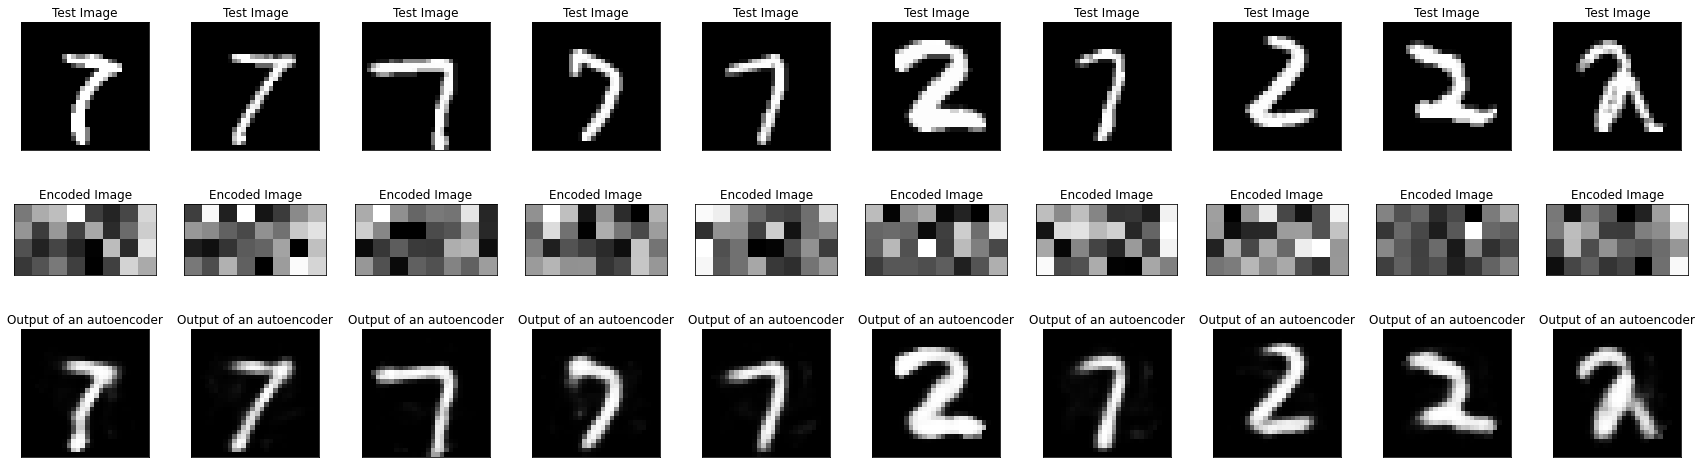

In [10]:
plotTheResults(xTest=xTestSet27,  encoded_imgs=encoded_imgs, autoencoded_imgs=autoencoded_imgs)

### Repeating procedure for different classes and plotting the results

Epoch 1/10
344/344 [==============================] - 1s 2ms/step - loss: 0.0080 - val_loss: 0.0065
Epoch 2/10
344/344 [==============================] - 1s 2ms/step - loss: 0.0066 - val_loss: 0.0061
Epoch 3/10
344/344 [==============================] - 1s 2ms/step - loss: 0.0062 - val_loss: 0.0058
Epoch 4/10
344/344 [==============================] - 1s 2ms/step - loss: 0.0060 - val_loss: 0.0057
Epoch 5/10
344/344 [==============================] - 1s 2ms/step - loss: 0.0058 - val_loss: 0.0056
Epoch 6/10
344/344 [==============================] - 1s 2ms/step - loss: 0.0057 - val_loss: 0.0055
Epoch 7/10
344/344 [==============================] - 1s 2ms/step - loss: 0.0057 - val_loss: 0.0055
Epoch 8/10
344/344 [==============================] - 1s 2ms/step - loss: 0.0056 - val_loss: 0.0055
Epoch 9/10
344/344 [==============================] - 1s 2ms/step - loss: 0.0055 - val_loss: 0.0054
Epoch 10/10
344/344 [==============================] - 1s 2ms/step - loss: 0.0055 - val_loss: 0.0054

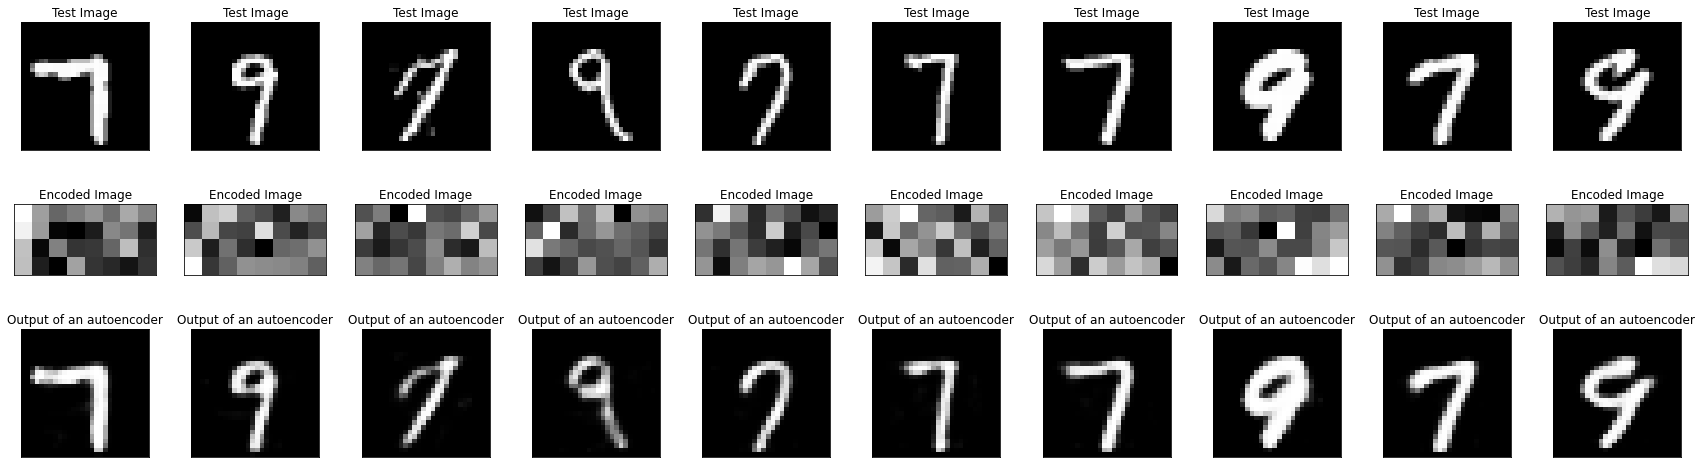

Epoch 1/10
325/325 [==============================] - 1s 2ms/step - loss: 0.0121 - val_loss: 0.0115
Epoch 2/10
325/325 [==============================] - 1s 2ms/step - loss: 0.0101 - val_loss: 0.0108
Epoch 3/10
325/325 [==============================] - 1s 2ms/step - loss: 0.0096 - val_loss: 0.0105
Epoch 4/10
325/325 [==============================] - 1s 2ms/step - loss: 0.0093 - val_loss: 0.0103
Epoch 5/10
325/325 [==============================] - 1s 2ms/step - loss: 0.0092 - val_loss: 0.0102
Epoch 6/10
325/325 [==============================] - 1s 2ms/step - loss: 0.0091 - val_loss: 0.0102
Epoch 7/10
325/325 [==============================] - 1s 2ms/step - loss: 0.0090 - val_loss: 0.0100
Epoch 8/10
325/325 [==============================] - 1s 2ms/step - loss: 0.0089 - val_loss: 0.0100
Epoch 9/10
325/325 [==============================] - 1s 2ms/step - loss: 0.0088 - val_loss: 0.0100
Epoch 10/10
325/325 [==============================] - 1s 2ms/step - loss: 0.0088 - val_loss: 0.0099

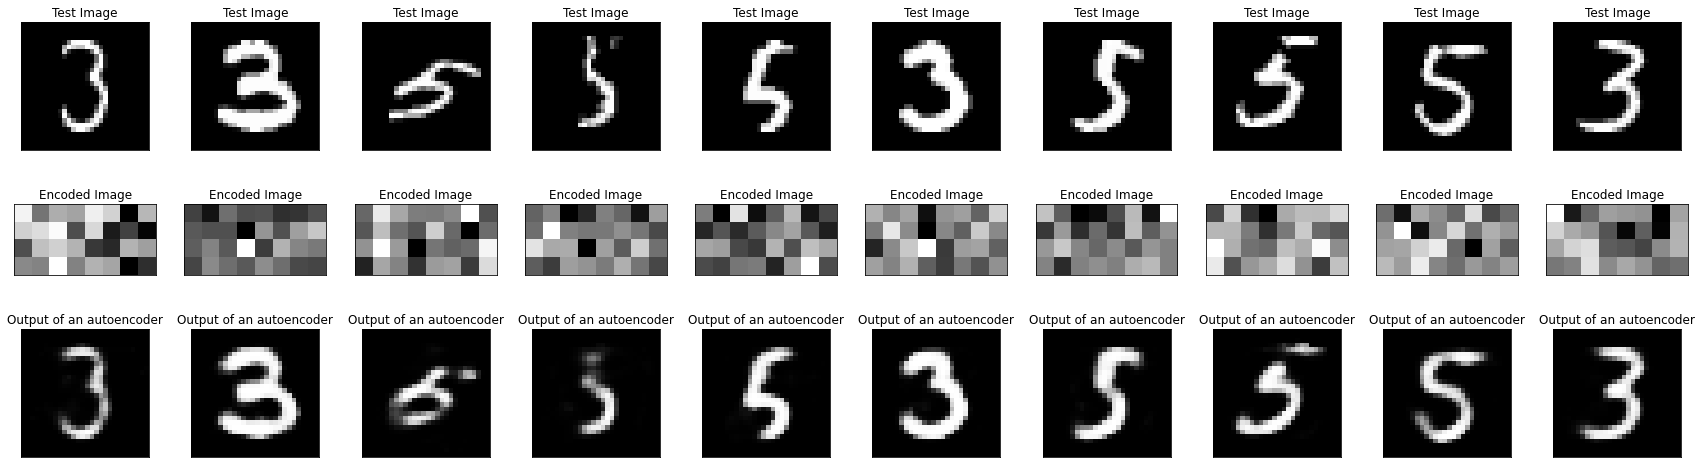

In [17]:
#* Separating the dataset for classes 1 and 7
(xTrainSet17, yTrainSet17), (xTestSet17,yTestSet17) = makeClassSet(xTrainSet=xTrain, yTrainSet=yTrain, xTestClass=xTest, yTestClass=yTest, firstclassNumber=9, secondclassNumber=7)

#* Separating the dataset for classes 2 and 5
(xTrainSet25, yTrainSet25), (xTestSet25,yTestSet25) = makeClassSet(xTrainSet=xTrain, yTrainSet=yTrain, xTestClass=xTest, yTestClass=yTest, firstclassNumber=3, secondclassNumber=5)

encoded_imgs, decoded_imgs, autoencoded_imgs = None, None, None
encoded_imgs, decoded_imgs, autoencoded_imgs = fitTheModel(xTrain=xTrainSet17,yTrain=yTrainSet17,xTest= xTestSet17,yTest= yTestSet17, encoderModel=encoder, decoderModel=decoder, autoencoderModel=autoencoder)
plotTheResults(xTest=xTestSet17,  encoded_imgs=encoded_imgs, autoencoded_imgs=autoencoded_imgs)

encoded_imgs, decoded_imgs, autoencoded_imgs = None, None, None
encoded_imgs, decoded_imgs, autoencoded_imgs = fitTheModel(xTrainSet25, yTrainSet25, xTestSet25, yTestSet25, encoder, decoder, autoencoder)
plotTheResults(xTest=xTestSet25,  encoded_imgs=encoded_imgs, autoencoded_imgs=autoencoded_imgs)